In [1]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Rosenbrock Density

In [2]:
# define ln_f(theta) as function where a single argument theta = (theta1, theta2)
def lnprob(theta):
    return -1./20 * (100*(theta[1] - theta[0]**2)**2 + (1-theta[0])**2)

In [3]:
# create meshgrid and associated lnprobs 
xx, yy = np.mgrid[-10:10:.01, -10:10:.01]
print('xx shape: {} | yy shape: {}'.format(xx.shape, yy.shape))
pos = np.vstack([xx.ravel(), yy.ravel()])
print('pos shape: {}'.format(pos.shape))
n_pos = xx.shape[0] * xx.shape[1]
lnprobs = np.array([lnprob(pos[:,i]) for i in range(n_pos)])
lnprobs = np.reshape(lnprobs, xx.shape)
print('lnprobs shape: {}'.format(lnprobs.shape))

xx shape: (2000, 2000) | yy shape: (2000, 2000)
pos shape: (2, 4000000)
lnprobs shape: (2000, 2000)


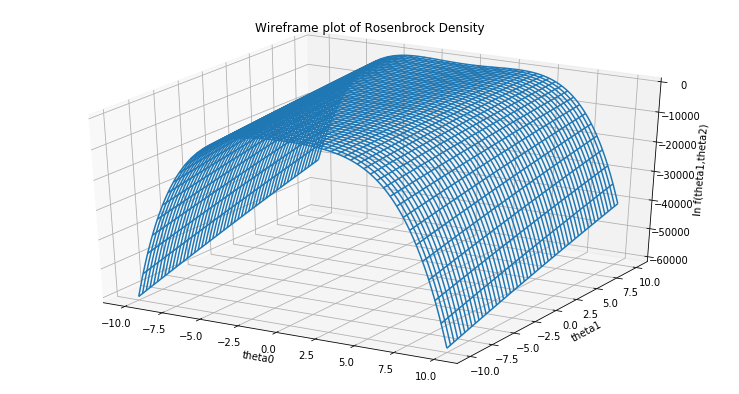

In [4]:
# create the plot
fig = plt.figure(figsize=(13, 7))
ax = fig.gca(projection='3d')
w = ax.plot_wireframe(xx, yy, lnprobs)
ax.set_xlabel('theta0')
ax.set_ylabel('theta1')
ax.set_zlabel('ln f(theta1,theta2)')
ax.set_title('Wireframe plot of Rosenbrock Density');

Based on the Rosenbrock Density wireframe plot above, we posit that: 
- (theta1, theta2) = (0,0) seems to be a good place to initialize our MCMC walker 
- theta0 has a smaller variance than theta1, which might instruct us to pick a larger variance for the latter in our proposal function 

## Diagnostic Helper Functions 

In [313]:
def convergence_heuristics(samples, n_segments=4):
    """ Perform basic convergence check by splitting up chain into N continuous segments (default=4) 
        to see if they exhibit similar empirical means and variances """
    
    # convert samples to pandas for easy data manipulation
    df = pd.DataFrame(samples, columns=['theta0', 'theta1'])
    
    # split into segments 
    samples_per_segment = len(df) / n_segments
    df['segment'] = np.floor(df.index / samples_per_segment).astype(int) + 1
    
    # compute mean and std for each parameter in each segment 
    stats = df.groupby('segment')['theta0', 'theta1'].agg([np.mean, np.std])
    
    return np.round(stats,3).T

In [374]:
def trace_plot(samples):
    """ Plots parameter samples as a function of step number """
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 7))

    for i, ax in enumerate(axes):
        param_vals = pd.Series(my_samples[:,i])
        ax.plot(param_vals, label='Theta{}'.format(i+1))
        ax.set_xlabel('Step Number')
        ax.set_ylabel('Theta{} Value'.format(i+1))
        ax.legend()

    plt.tight_layout()

In [421]:
def plot_1d_histograms(samples): 
    """ Plots histograms of each parameter's samples side-by-side. 
        Accepts an array for a single model, or a dictionary for comparison of multiple models (latter overlayed) """

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # convert input to dict if not already a dict 
    samples_dict = samples if isinstance(samples, dict) else {'my_sampler': samples}
    
    for i, ax in enumerate(axes):
        for sampler in samples_dict.keys(): 
            ax.hist(samples_dict[sampler][:,i], bins=100, histtype='step', density=True, label=sampler)
            ax.set_ylabel('Density')
            ax.set_xlabel('Theta{}'.format(i+1))
            ax.set_title('Distribution of Theta{}'.format(i+1))
            ax.legend()

In [438]:
def plot_2d_scatterplot(samples_dict, samples_to_plot=10000):
    """ Compares scatter plots of (theta1, theta2) samples between two samplers """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

    for i, (ax, sampler) in enumerate(zip(axes, samples_dict.keys())):
        
        # thin chain to prevent scatterplot from being a giant blob 
        samples = samples_dict[sampler]
        idx = np.random.randint(len(samples), size=samples_to_plot)
        thinned = samples[idx, :]

        # create scatterplot
        ax.scatter(thinned[:,0], thinned[:,1], alpha=0.1, s=1)
        ax.set_xlabel('Theta0')
        ax.set_ylabel('Theta1')
        ax.set_title('Samples from {}'.format(sampler))

## My Sampler

To Dos:
- scatter plot of (theta0, theta1)
- fold proposal func into mySampler class, passing in cov as an argument
- tune cov by plotting acceptance fraction against cov 
- compute autocrrelation time
- add multiple walkers
- add burn in 

In [194]:
class mySampler():
    
    def __init__(self, density, proposal): 
        self.density = density 
        self.proposal = draw_from_q
    
    def run_mcmc(self, steps, initial_x): 
        
        # initialize x and results variables 
        x = initial_x
        samples = [] 
        accepted = 0

        # start walker 
        for i in range(steps):
            r = np.random.uniform()
            proposed_x = draw_from_q(x)
            if lnprob(proposed_x) - lnprob(x) > np.log(r):
                x = proposed_x
                accepted += 1 
            samples.append(x)
        
        # compile and return results 
        self.samples = np.array(samples)
        self.accepted_frac = accepted / steps
        print("MCMC completed. Acceptance fraction is {0:.3f}".format(self.accepted_frac))
        return self.samples, self.accepted_frac

In [235]:
def draw_from_q(x):
    return np.random.multivariate_normal(mean=[x[0],x[1]], cov=[[1,0],[0,5]])

In [236]:
my_sampler = mySampler(lnprob, draw_from_q)
my_samples, my_accept_frac = my_sampler.run_mcmc(steps=10**5, initial_x=(0,0))

MCMC completed. Acceptance fraction is 0.102


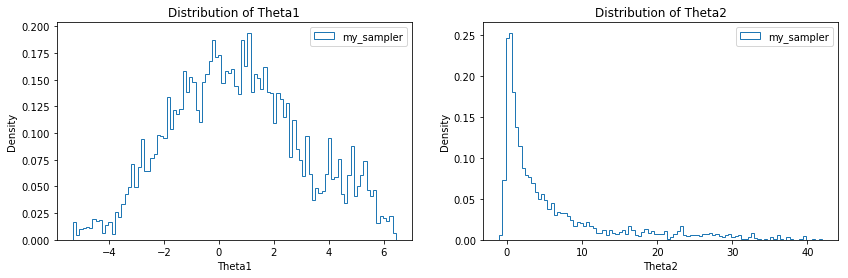

In [423]:
plot_1d_histograms(my_samples)

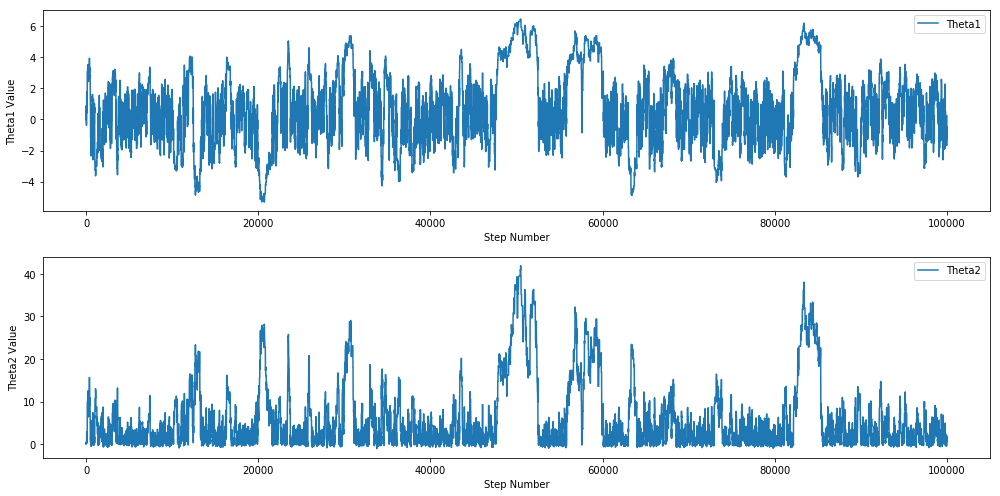

In [376]:
trace_plot(my_samples)

In [316]:
convergence_heuristics(my_samples, n_segments=4)

segment          1      2       3      4
theta0 mean -0.198  0.971   1.168  0.801
       std   2.119  2.265   2.698  2.182
theta1 mean  4.527  6.066   8.645  5.396
       std   5.648  7.652  10.238  8.002

## Using emcee 

In [241]:
# initialize sampler 
ndim, nwalkers = 2, 100
theta0 = np.random.rand(ndim*nwalkers).reshape((nwalkers, ndim))
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# burn in
pos, prob, state = emcee_sampler.run_mcmc(theta0, 100);
emcee_sampler.reset() 

# get samples 
emcee_sampler.run_mcmc(pos, 10**3)
emcee_samples = emcee_sampler.flatchain
emcee_accept_frac = np.mean(emcee_sampler.acceptance_fraction)
print("MCMC with emcee sampler completed. Mean acceptance fraction is {0:.3f}".format(emcee_accept_frac))

MCMC with emcee sampler completed. Mean acceptance fraction is 0.339


## Comparing our Samplers

### Efficiency 

In [242]:
# compare acceptance function 
print("Emcee sampler is much more efficient with a higher acceptance fraction than mine:")
print("Emcee sampler: {0:.3f}".format(emcee_accept_frac))
print("My sampler: {0:.3f}".format(my_accept_frac))

Emcee sampler is much more efficient with a higher acceptance fraction than mine:
Emcee sampler: 0.339
My sampler: 0.102


### Distribution of Samples

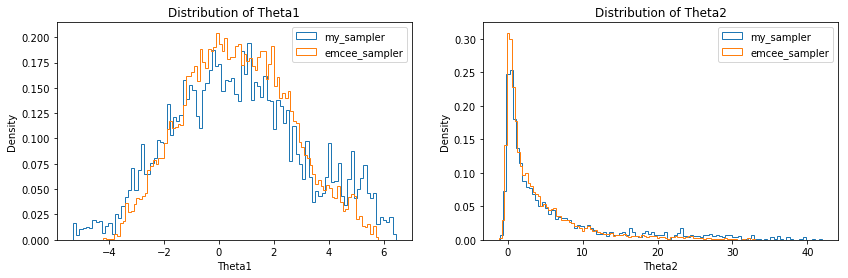

In [424]:
compare_samples = {'my_sampler': my_samples, 'emcee_sampler': emcee_samples} 
plot_1d_histograms(compare_samples)

### Scatterplot 

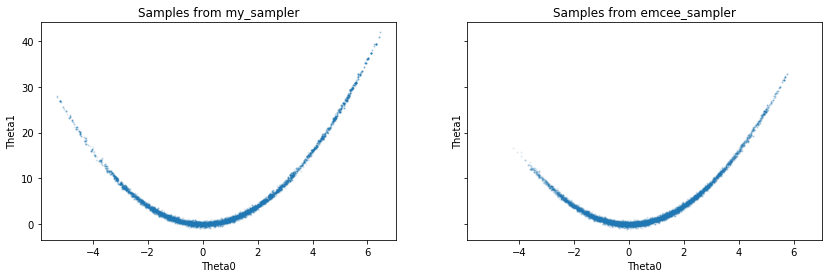

In [439]:
plot_2d_scatterplot(samples)